In [1]:
import json
import pandas as pd
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['local']
col = db['cleaned_data']
source_sub = []

features = []

#class PacketDataa:

def flatten_data(y):
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out



with open("local.traffic_capture_2.json", 'r') as f:
    data = json.load(f)
    print(len(data))
    for j in range(len(data)):
        jsonobj = json.loads(json.dumps(data[j]))
        packetjson = json.loads(jsonobj["pcap"])
        
        for packet in range(len(packetjson)):
            subobj = json.loads(json.dumps(packetjson[packet]['_source']))
            flatobj = {
                "label" : jsonobj["event_type"]
            }
            flatobj.update(flatten_data(subobj))
            for keys in flatobj.keys():
                if keys not in features:
                    features.append(keys)
            col.insert_one(flatobj)


266


In [3]:
import pymongoarrow.api as pymongoarrow
from pandas import json_normalize

cursor = col.find()
list_data = list(cursor)
df = json_normalize(list_data)
df = df.drop('_id', axis=1)

working_features = [
    'layers_frame_frame.time_delta',
    'layers_frame_frame.time_relative',
    'layers_frame_frame.len',
    'layers_frame_frame.cap_len',
    'layers_eth_eth.dst_tree_eth.dst.oui',
    'layers_eth_eth.src_tree_eth.src.oui',
    'layers_eth_eth.src_tree_eth.addr.oui',
    'layers_ip_ip.hdr_len',
    'layers_ip_ip.len',
    'layers_ip_ip.ttl',
    'layers_ip_ip.checksum.status',
    'layers_ip_ip.src',
    'layers_ip_ip.addr',
    'layers_ip_ip.src_host',
    'layers_ip_ip.host',
    'layers_ip_ip.dst',
    'layers_ip_ip.dst_host',
    'layers_tcp_tcp.srcport',
    'layers_tcp_tcp.dstport',
    'layers_tcp_tcp.port',
    'layers_tcp_tcp.len',
    'layers_tcp_tcp.seq_raw',
    'layers_tcp_tcp.hdr_len',
    'layers_tcp_tcp.window_size_value',
    'layers_tcp_tcp.analysis_tcp.analysis.bytes_in_flight',
    'layers_tcp_tcp.analysis_tcp.analysis.push_bytes_sent',
    'layers_tls_tls.record_tls.record.content_type',
    'layers_tls_tls.record_tls.record.length'
]

unencoded_features = ['layers_frame_frame.interface_id_tree_frame.interface_name', 
                'layers_frame_frame.time',
               'layers_frame_frame.time_utc',
               'layers_frame_frame.protocols',
               'layers_eth_eth.dst',
               'layers_eth_eth.dst_tree_eth.addr',
               'layers_eth_eth.src',
               'layers_eth_eth.dst_tree_eth.dst_resolved',
               'layers_eth_eth.dst_tree_eth.dst.oui_resolved',
               'layers_eth_eth.dst_tree_eth.addr_resolved',
               'layers_eth_eth.dst_tree_eth.addr.oui_resolved',
               'layers_eth_eth.src_tree_eth.src_resolved',
                'layers_eth_eth.src_tree_eth.addr',
                'layers_eth_eth.src_tree_eth.addr_resolved',
                'layers_eth_eth.type',
                'layers_ip_ip.dsfield',
                'layers_arp_arp.proto.type',
                'layers_arp_arp.src.hw_mac',
                'layers_arp_arp.dst.hw_mac',
                'layers_eth_eth.src_tree_eth.src.oui_resolved',
                'layers_eth_eth.src_tree_eth.addr_resolved',
                'layers_eth_eth.src_tree_eth.addr.oui_resolved',
                'layers_ip_ip.id',
                'layers_ip_ip.flags',
                'layers_ip_ip.checksum',
                'layers_tcp_tcp.completeness_tree_tcp.completeness.str',
                'layers_tcp_tcp.flags',
                'layers_tcp_tcp.flags_tree_tcp.flags.str',
                'layers_tcp_tcp.checksum',
                'layers_tcp_tcp.payload',
                'layers_tls_tls.record_tls.app_data',
                'layers_tls_tls.record_tls.record.version',
                'layers_tcp_tcp.segment_data'
               ]
ipaddr = [
    'layers_arp_arp.src.proto_ipv4',
    'layers_arp_arp.dst.proto_ipv4',
    'layers_ip_ip.src',
    'layers_ip_ip.addr',
    'layers_ip_ip.src_host',
    'layers_ip_ip.host',
    'layers_ip_ip.dst',
    'layers_ip_ip.dst_host'
]



for ipadd in ipaddr:
    df[ipadd] = df[ipadd].str.replace(r'.', '')




labels = df['label']
features = df.drop('label', axis=1)
workingdf = features[working_features]



In [13]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(labels.describe())
X_train, X_test, y_train, y_test = train_test_split(workingdf, labels, test_size=0.3)

feature_names = [ f'{workingdf.columns[i]}' for i in range(workingdf.shape[1])]


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

print(accuracy_score(y_test, y_hat))

count         26600
unique            3
top       live_view
freq           9800
Name: label, dtype: object
0.9948621553884712


In [36]:


high_information = clf.feature_importances_

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': high_information})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

In [37]:
print(feature_importance_df)

                                              feature  importance
16                              layers_ip_ip.dst_host    0.289452
1                    layers_frame_frame.time_relative    0.196276
17                             layers_tcp_tcp.srcport    0.122600
13                              layers_ip_ip.src_host    0.109899
18                             layers_tcp_tcp.dstport    0.092361
0                       layers_frame_frame.time_delta    0.059877
3                          layers_frame_frame.cap_len    0.040817
21                             layers_tcp_tcp.seq_raw    0.020616
8                                    layers_ip_ip.len    0.015168
2                              layers_frame_frame.len    0.010829
9                                    layers_ip_ip.ttl    0.009612
14                                  layers_ip_ip.host    0.008781
23                   layers_tcp_tcp.window_size_value    0.008033
19                                layers_tcp_tcp.port    0.004671
11        

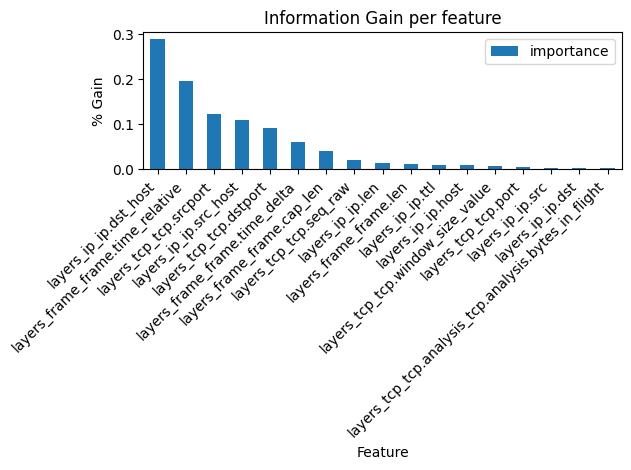

In [40]:
import matplotlib.pyplot as plt

query = feature_importance_df.query('importance <= 0.001')
feature_importance_df = feature_importance_df[feature_importance_df['importance'] > 0.001]
ax = feature_importance_df.plot(kind='bar')
ax.set_xticklabels(feature_importance_df['feature'])
plt.xticks(rotation=45, ha='right') 
plt.title('Information Gain per feature')
plt.xlabel('Feature')
plt.ylabel('% Gain')
plt.tight_layout()
plt.show()